在我们之前的优化算法中，无论是梯度下降、随机梯度下降、小批量随机梯度下降还是使用动量法，模型参数中的每一个元素在相同时刻都使用同一个学习率来自我迭代。

举个例子，当一个模型的损失函数为LL，参数为一个多维向量[x1,x2]⊤时，该向量中每一个元素在更新时都使用相同的学习率，例如在学习率为ηη的梯度下降中：

x1:=x1−η∂L∂x1
x2:=x2−η∂L∂x2
其中元素x1x1和x2x2都使用相同的学习率ηη来自我迭代。如果让x1x1和x2x2使用不同的学习率自我迭代呢？

Adagrad就是一个在迭代过程中不断自我调整学习率，并让模型参数中每个元素都使用不同学习率的优化算法。

Adagrad的算法会使用一个梯度按元素平方的累加变量ss，并将其中每个元素初始化为0。在每次迭代中，首先计算小批量梯度 gg，然后将该梯度按元素平方后累加到变量ss：

s:=s+g⊙g

然后我们将模型参数中每个元素的学习率通过按元素操作重新调整一下：

g′:=η/(√s+ϵ)⊙g

其中ηη是初始学习率，ϵ是为了维持数值稳定性而添加的常数，例如10−7。请注意其中按元素开方、除法和乘法的操作。这些按元素操作使得模型参数中每个元素都分别拥有自己的学习率。

需要强调的是，由于梯度按元素平方的累加变量s出现在分母，Adagrad的核心思想是：如果模型损失函数有关一个参数元素的偏导数一直都较大，那么就让它的学习率下降快一点；反之，如果模型损失函数有关一个参数元素的偏导数一直都较小，那么就让它的学习率下降慢一点。然而，由于s一直在累加按元素平方的梯度，每个元素的学习率在迭代过程中一直在降低或不变。所以在有些问题下，当学习率在迭代早期降得较快时且当前解依然不理想时，Adagrad在迭代后期可能较难找到一个有用的解。

最后的参数迭代步骤与小批量随机梯度下降类似。只是这里梯度前的学习率已经被调整过了：

x:=x−g′

In [1]:
# Adagrad算法
def adagrad(params, sqrs, lr, batch_size):
    eps_stable = 1e-7
    for param, sqr in zip(params, sqrs):
        g = param.grad / batch_size
        sqr[:] += nd.square(g)
        div = lr * g / nd.sqrt(sqr + eps_stable)
        param[:] -= div

In [2]:
from mxnet import ndarray as nd
import mxnet as mx
from mxnet import autograd
from mxnet import gluon
import random

mx.random.seed(1)
random.seed(1)

# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = nd.random_normal(scale=1, shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(scale=1, shape=y.shape)
dataset = gluon.data.ArrayDataset(X, y)

# 构造迭代器。
import random
def data_iter(batch_size):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for batch_i, i in enumerate(range(0, num_examples, batch_size)):
        j = nd.array(idx[i: min(i + batch_size, num_examples)])
        yield batch_i, X.take(j), y.take(j)

# 初始化模型参数。
def init_params():
    w = nd.random_normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    sqrs = []
    for param in params:
        param.attach_grad()
        # 把梯度按元素平方的累加变量初始化为和参数形状相同的零张量。
        sqrs.append(param.zeros_like())
    return params, sqrs

# 线性回归模型。
def net(X, w, b):
    return nd.dot(X, w) + b

# 损失函数。
def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape)) ** 2 / 2

E:\software\anaconda\envs\gluon\lib\site-packages\urllib3\contrib\pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np

def train(batch_size, lr, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    [w, b], sqrs = init_params()
    total_loss = [np.mean(square_loss(net(X, w, b), y).asnumpy())]

    # 注意epoch从1开始计数。
    for epoch in range(1, epochs + 1):
        for batch_i, data, label in data_iter(batch_size):
            with autograd.record():
                output = net(data, w, b)
                loss = square_loss(output, label)
            loss.backward()
            adagrad([w, b], sqrs, lr, batch_size)
            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(X, w, b), y).asnumpy()))
        print("Batch size %d, Learning rate %f, Epoch %d, loss %.4e" %
              (batch_size, lr, epoch, total_loss[-1]))
    print('w:', np.reshape(w.asnumpy(), (1, -1)),
          'b:', b.asnumpy()[0], '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

Batch size 10, Learning rate 0.900000, Epoch 1, loss 5.3230e-05
Batch size 10, Learning rate 0.900000, Epoch 2, loss 4.9388e-05
Batch size 10, Learning rate 0.900000, Epoch 3, loss 4.9256e-05
w: [[ 1.99946404 -3.39996123]] b: 4.19967 



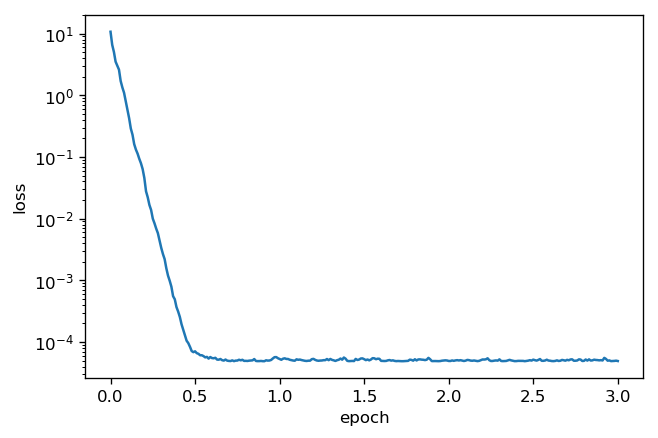

In [4]:
train(batch_size=10, lr=0.9, epochs=3, period=10)

### 结论

Adagrad是一个在迭代过程中不断自我调整学习率，并让模型参数中每个元素都使用不同学习率的优化算法。

In [5]:
import mxnet as mx
from mxnet import autograd
from mxnet import gluon
from mxnet import ndarray as nd
import numpy as np
import random

mx.random.seed(1)
random.seed(1)

# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = nd.random_normal(scale=1, shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(scale=1, shape=y.shape)
dataset = gluon.data.ArrayDataset(X, y)

net = gluon.nn.Sequential()
net.add(gluon.nn.Dense(1))
square_loss = gluon.loss.L2Loss()

In [6]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def train(batch_size, lr, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True)
    # Adagrad。
    trainer = gluon.Trainer(net.collect_params(), 'adagrad',
                            {'learning_rate': lr})
    data_iter = gluon.data.DataLoader(dataset, batch_size, shuffle=True)
    total_loss = [np.mean(square_loss(net(X), y).asnumpy())]

    for epoch in range(1, epochs + 1):
        for batch_i, (data, label) in enumerate(data_iter):
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)
            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(X), y).asnumpy()))
        print("Batch size %d, Learning rate %f, Epoch %d, loss %.4e" %
              (batch_size, trainer.learning_rate, epoch, total_loss[-1]))

    print('w:', np.reshape(net[0].weight.data().asnumpy(), (1, -1)),
          'b:', net[0].bias.data().asnumpy()[0], '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

Batch size 10, Learning rate 0.900000, Epoch 1, loss 5.0563e-05
Batch size 10, Learning rate 0.900000, Epoch 2, loss 4.9438e-05
Batch size 10, Learning rate 0.900000, Epoch 3, loss 4.9941e-05
w: [[ 1.99863005 -3.39978027]] b: 4.20027 



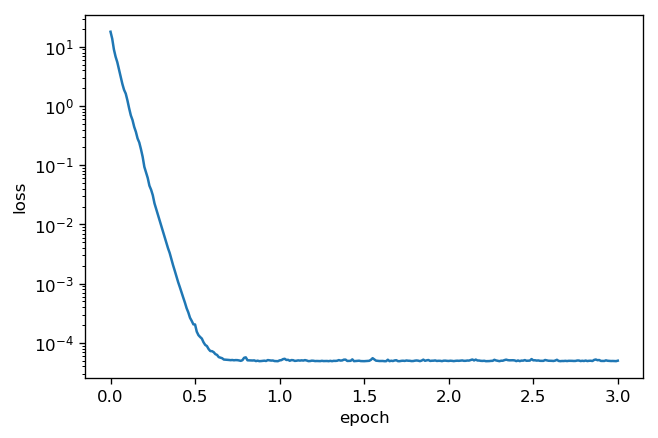

In [10]:
train(batch_size=10, lr=0.9, epochs=3, period=10)

Batch size 10, Learning rate 0.999990, Epoch 1, loss 4.9160e-05
Batch size 10, Learning rate 0.999990, Epoch 2, loss 4.9088e-05
Batch size 10, Learning rate 0.999990, Epoch 3, loss 4.9661e-05
w: [[ 1.99892414 -3.39968443]] b: 4.20047 



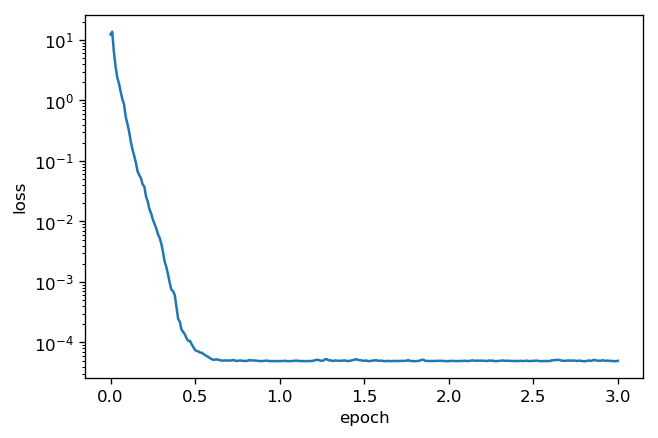

In [9]:
train(batch_size=10, lr=0.99999, epochs=3, period=10)

Batch size 10, Learning rate 0.300000, Epoch 1, loss 1.0448e-01
Batch size 10, Learning rate 0.300000, Epoch 2, loss 2.6701e-03
Batch size 10, Learning rate 0.300000, Epoch 3, loss 1.1648e-04
w: [[ 2.00134182 -3.39880538]] b: 4.18859 



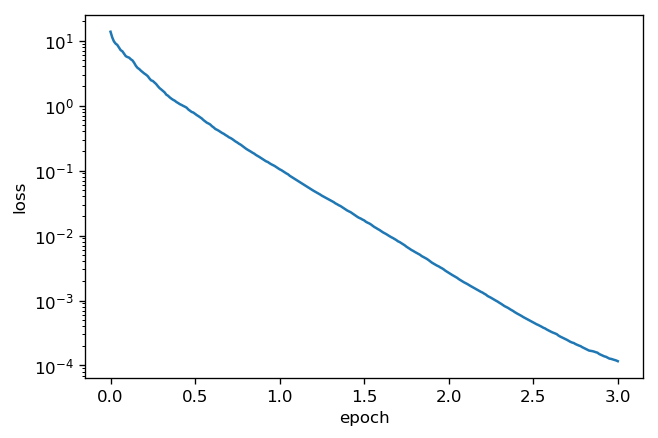

In [11]:
train(batch_size=10, lr=0.3, epochs=3, period=10)